In [40]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
#from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
Draw = lambda *args, **kwargs : None

import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()

from myPackage import evalOnLine
from meshGen import mesh2DLaminates


rotated = True
modelHalfAir = False

moartaring=False

onlySmooth = False
onlyRough = False

# class myDraw:
#     scenes = {}
#     def __init__(self, *args, **kwargs):
#         if id(args[0]) not in myDraw.scenes.keys():
#             myDraw.scenes.update({id(args[0]):Draw(*args, **kwargs)})
#         else:
#             myDraw.scenes[id(args[0])].Draw()
#     def updateAll():
#         for s in myDraw.scenes.values():
#             s.Redraw()

In [41]:
lambda1 = 1
lambda2 = 1000

order0 = 2

In [42]:
D = 0.04
d = 0.02

ff = 0.7


numSheets = 5

maxh_edges = d/numSheets*1/2 * 0.1


if onlySmooth:
    rotated = False

if onlyRough:
    rotated = True




## 3. All together
### 3.1. Reference Solution 

In [43]:
import importlib

import meshGen as mg
mg = importlib.reload(mg)
mesh2DLaminates = mg.mesh2DLaminates
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, maxh_edges=[maxh_edges, maxh_edges], fullProblemX=True, onlySmooth = onlySmooth, onlyRough = onlyRough, rotated=rotated, modelHalfAir=modelHalfAir, quad_dominated=False)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))


maxh_edges [0.0002, 0.0002]
Boundaries {'ibottom', 'bottom', 'right', 'top', 'itop', 'iright', 'ileft', 'left'}
Materials {'outer', 'inner', 'insulation'}


In [44]:
Draw(meshRef)

In [45]:
lam = meshRef.MaterialCF({"inner":lambda2, "outer":lambda1, "insulation":lambda1, "gap":lambda1, "multiscale":lambda2})
def calcRef():
    fes = H1(meshRef, order=order0, dirichlet="left|right")

    u,v = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += lam * grad(u) * grad(v) * dx

    prec = Preconditioner(a, "direct")


    sol.Set(1 * x/Norm(x), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(lam * grad(sol), grad(sol)), meshRef, definedon=meshRef.Materials("inner|insulation"))
    
    return sol, energy

sol_ref, energy_ref = calcRef()

H_ref = -grad(sol_ref)
B_ref = lam  * H_ref


CG iteration 1, residual = 3.978562639305685     
CG iteration 2, residual = 9.004895854809739e-12     


In [46]:


print(f"energy:\t{energy_ref}")
print(sol_ref)
Draw(sol_ref, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})
Draw( H_ref, meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max = 200)
Draw(B_ref, meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=400)


energy:	0.8262752092580621
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 0
autoupdate = 0



### 3.2 Multiscale 

In [47]:
import cempy as cp
mg = importlib.reload(mg)
mesh2DLaminates = mg.mesh2DLaminates
cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, onlySmooth=onlySmooth, onlyRough=onlyRough, domainNameHalfAir="multiscale", maxh_edges= (maxh_edges, maxh_edges), rotated=rotated, modelGap=True)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh
print(meshMS.GetMaterials())



maxh_edges (0.0002, 0.0002)
('outer', 'outer', 'multiscale', 'gap', 'gap')


In [48]:
Draw(CF([1, 2, 3, 4, 5, 6]), meshMS)
from myPackage import drawBndAll

# drawBndAll(meshMS, drawFunc=Draw, block=False)

In [49]:
import importlib
import MS_helper_functions as ms
ms = importlib.reload(ms)
cl_Phi = ms.cl_Phi

getIntegrand4BFI = ms.getIntegrand4BFI
gradgradMS = ms.gradgradMS
pyLobatto = ms.pyLobatto
pydxLobatto = ms.pydxLobatto
getPhiPhiValue = ms.getPhiPhiValue
pyPhiFunction = ms.pyPhiFunction



cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = True
cl_Phi.orientation = 1 if rotated else 0

if False:
    import cempy as cp
    importlib.reload(cp)
    
    
    cl_Phi.phiFunction = cp.phiFunctions.Lobatto
    cl_Phi.dzPhiFunction = cp.phiFunctions.dxLobatto
else:
    cl_Phi.phiFunction = pyLobatto
    cl_Phi.dzPhiFunction = pydxLobatto



In [60]:
force_full_Phi = True


smooth_fun_Fe = lambda x: 1e3 * lambda1/lambda2 * (x**2/cl_Phi.dFe * 1 - (cl_Phi.dFe/4 * 1))
smooth_fun_0 = lambda x: 1e3*(-(x - (cl_Phi.d0/2+cl_Phi.dFe/2))**2/ cl_Phi.d0 * 1 + cl_Phi.d0/4 * 1)


smoothPhi2 = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), 
    [smooth_fun_Fe, smooth_fun_0], numSheets, ff, cl_Phi.orientation, name = "smoothPhi2", order="sm2", modelHalfAir=modelHalfAir)


def calcMultiscale(useGradients=True, drawPhis=True):
    domains = "multiscale|gap"
    if onlySmooth:
        domains = "multiscale"

    roughbnd = "left|right" if rotated else "top|bottom"
    smoothbnd = "itop|ibottom" if rotated else "ileft|iright"

    if onlySmooth:
        roughbnd = ""

    print("moartaring", moartaring)
    print("modelHalfAir", modelHalfAir)
    print("domains", domains)
    print("roughbnd", roughbnd)
    print("smoothbnd", smoothbnd)

    # microshape functions

    

    orderPhi = [
            cl_Phi(0, fes_order=order0, material=domains, dirichlet=roughbnd, useGradients=True, useAbsolutes=False), 
            cl_Phi(1, fes_order=order0, material=domains, dirichlet=roughbnd, useGradients=True, useAbsolutes=True, modelHalfAir=True), 
            # cl_Phi(1, fes_order=2, material=domains, dirichlet=roughbnd, useGradients=True, 
            #         specialFirstLast=True, 
            #         specialFirstLast_func=[lambda x : 1/cl_Phi.dFe*(x+cl_Phi.dFe/2), lambda x:1/cl_Phi.dFe*(x-cl_Phi.dFe/2)], 
            #         specialFirstLast_dzfunc=[lambda x : 1/cl_Phi.dFe, lambda x : 1/cl_Phi.dFe], 
            #         ), 


            cl_Phi([smoothPhi2, smoothPhi2.getDiff()], fes_order=order0, material=domains, dirichlet=roughbnd, useGradients=True, modelHalfAir=False),

            # cl_Phi(2, fes_order=order0, material=domains, dirichlet=roughbnd, inAir=False, useGradients=True), 
            cl_Phi(2, fes_order=order0, material=domains, dirichlet=roughbnd, inIron=False, modelHalfAir=False), 


            # cl_Phi(4, fes_order=1, material=domains, dirichlet=roughbnd, useGradients=True, inAir=False, modelHalfAir=False), 
            # cl_Phi(4, fes_order=1, material=domains, dirichlet=roughbnd, useGradients=True, inIron=False, modelHalfAir=False), 
        ]

    if not moartaring:
        orderPhi = orderPhi[1:]

    if drawPhis:
        cl_Phi.plotEvaluated(orderPhi, nFig=1)

    VSpace = []
    # # u0 
    domains_outer = "outer"
    if not moartaring:
        domains_outer += "|" + domains
    VSpace.append(H1(meshMS, order=order0, dirichlet="left|right", definedon=meshMS.Materials(domains_outer))) 
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet))
    VSpace = FESpace(VSpace)


    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
       

    cl_gradgradMS = gradgradMS(orderPhi, sol, addPhi0Outer=True, secondOrder=False)

    a = BilinearForm(VSpace, symmetric=False)
    f = LinearForm(VSpace)

    a += lambda1  * grad(cl_gradgradMS.trials[0]) * grad(cl_gradgradMS.tests[0]) * dx("outer")
    if moartaring:
        slice_inner = slice(1, len(cl_gradgradMS.gradu))
    else:
        slice_inner = slice(0, len(cl_gradgradMS.gradu))


    a += getIntegrand4BFI(cl_gradgradMS.gradu[slice_inner], cl_gradgradMS.gradv[slice_inner], lambda2, lambda1, force_full_Phi=force_full_Phi) * dx("multiscale")
    a += getIntegrand4BFI(cl_gradgradMS.gradu[slice_inner], cl_gradgradMS.gradv[slice_inner], lambda1, lambda1, force_full_Phi=force_full_Phi) * dx("gap")
    # a += getIntegrand4BFI(cl_gradgradMS.gradu, cl_gradgradMS.gradv, lambda1, lambda1, force_full_Phi=False, modelHalfAir=False, force_num_int=True) * dx("gap")



    alpha = 3.5
    h = specialcf.mesh_size

    u_start = 1 if moartaring else 0
    # alpha = 1e6
    d_coupling = -d/2 if modelHalfAir else -d/2 + cl_Phi.d0/2


    # absolutes
    u_range = range(u_start, len(cl_gradgradMS.u))
    u_range = list(range(2, len(cl_gradgradMS.u)))
    u_range = [0] + u_range

    # u_range = [u_start]
    um_bottom = sum(cl_gradgradMS.u[i][0] * cl_gradgradMS.u[i][1].DirectEvaluate(-d_coupling) for i in u_range)
    vm_bottom = sum(cl_gradgradMS.v[i][0] * cl_gradgradMS.v[i][1].DirectEvaluate(-d_coupling) for i in u_range)

    um_top = sum(cl_gradgradMS.u[i][0] * cl_gradgradMS.u[i][1].DirectEvaluate(d_coupling) for i in u_range)
    vm_top = sum(cl_gradgradMS.v[i][0] * cl_gradgradMS.v[i][1].DirectEvaluate(d_coupling) for i in u_range)

    jump_u_top = cl_gradgradMS.u[0][0] - um_top
    jump_u_bottom = cl_gradgradMS.u[0][0] - um_bottom

    jump_v_top = cl_gradgradMS.v[0][0] - vm_top
    jump_v_bottom = cl_gradgradMS.v[0][0] - vm_bottom

    # gradients
    grad_range = range(u_start, len(cl_gradgradMS.gradu))
    # grad_range = list(range(3, len(cl_gradgradMS.gradu)))
    # grad_range = [1]
    
    gradum_bottom = sum(cl_gradgradMS.gradu_trace_n[i][0] * cl_gradgradMS.gradu_trace_n[i][1].DirectEvaluate(-d_coupling) for i in grad_range)
    gradvm_bottom = sum(cl_gradgradMS.gradv_trace_n[i][0] * cl_gradgradMS.gradv_trace_n[i][1].DirectEvaluate(-d_coupling) for i in grad_range)

    gradum_top = sum(cl_gradgradMS.gradu_trace_n[i][0] * cl_gradgradMS.gradu_trace_n[i][1].DirectEvaluate(d_coupling) for i in grad_range)
    gradvm_top = sum(cl_gradgradMS.gradv_trace_n[i][0] * cl_gradgradMS.gradv_trace_n[i][1].DirectEvaluate(d_coupling) for i in grad_range)

    lambda_inner = lambda1 if modelHalfAir else lambda2

    jump_Bu_top = lambda1 * cl_gradgradMS.gradu_trace_n[0][0] - lambda_inner * gradum_top
    jump_Bu_bottom = lambda1 * cl_gradgradMS.gradu_trace_n[0][0] - lambda_inner * gradvm_bottom

    jump_Bv_top = lambda1 * cl_gradgradMS.gradv_trace_n[0][0] - lambda_inner * gradvm_top
    jump_Bv_bottom = lambda1 * cl_gradgradMS.gradv_trace_n[0][0] - lambda_inner * gradvm_bottom

    # couple u
    if False:
        #[u][v]
        # a += alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[u_start:], cl_gradgradMS.v[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[u_start:], cl_gradgradMS.v[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[:1], cl_gradgradMS.v[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[:1], cl_gradgradMS.v[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        a += alpha*order0**2/h  * (jump_u_top)  * (jump_v_top)  *ds("itop")
        a += alpha*order0**2/h  * (jump_u_bottom)  * (jump_v_bottom)  *ds("ibottom")
        

    if False:
        #{dn u } [ v]
        a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[u_start:], cl_gradgradMS.v[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[u_start:], cl_gradgradMS.v[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[:1], cl_gradgradMS.v[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[:1], cl_gradgradMS.v[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += (lambda_inner * jump_Bu_top)  * (jump_v_top)  *ds("itop")
        # a += (lambda_inner * jump_Bu_bottom)  * (jump_v_bottom)  *ds("ibottom")


        #[ u] {dn v } 
        a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[u_start:], cl_gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[u_start:], cl_gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[:1], cl_gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[:1], cl_gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += (lambda_inner * jump_Bv_bottom)  * (jump_u_top)  *ds("itop")
        # a += (lambda_inner * jump_Bv_bottom)  * (jump_u_bottom)  *ds("ibottom")

    # couple fluxes
    if True:
        # [dn u] [ dn v]
        alpha = 20
        a += alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[u_start:], cl_gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[u_start:], cl_gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[:1], cl_gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[:1], cl_gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        # a += alpha*order0**2/h  * (jump_Bu_top)  * (jump_Bv_top)  *ds("itop")
        # a += alpha*order0**2/h  * (jump_Bu_bottom)  * (jump_Bv_bottom)  *ds("ibottom")


    # couple hesse 
    if False:

        #{gradgrad(u)_n_n } [ dn v]
        a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.hesse_u_trace_nn, cl_gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.hesse_u_trace_nn, [cl_gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI([cl_gradgradMS.hesse_u_trace_nn[0]], cl_gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -cl_gradgradMS.getIntegrand4BFI([cl_gradgradMS.hesse_u_trace_nn[0]], [cl_gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)


        #[ dn u] {gradgrad(v)_n_n } 
        a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n, cl_gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI([cl_gradgradMS.gradu_trace_n[0]], cl_gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n, [cl_gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += -cl_gradgradMS.getIntegrand4BFI([cl_gradgradMS.gradu_trace_n[0]], [cl_gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)

    prec = Preconditioner(a,type="direct")  


    # dirichlet boundary values
    sol.components[0].Set(1 * x/Norm(x), BND)
    if moartaring:
        sol.components[1].Set(1 * x/Norm(x), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=30, tol = 1e-20)

    energy =  Integrate(getIntegrand4BFI(cl_gradgradMS.gradsol_pack, cl_gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                    definedon=meshMS.Materials("multiscale"))
    
    print("a norm", a.mat.AsVector().Norm())
    return sol, cl_gradgradMS.sol_pack, cl_gradgradMS.sol_comp, cl_gradgradMS.gradsol_comp, energy, cl_gradgradMS

    






In [61]:
sol_MS, sol_pack_MS, sol_comp_MS, H_comp, energy_MS, cl_gradgradMS = calcMultiscale(False, drawPhis=False)
H_MS = sum(H_comp)
H_MS.Compile()
print("Norm soll diff", Integrate((sum(sol_comp_MS) - sol_ref)* (sum(sol_comp_MS) - sol_ref)/( (sol_ref)**2) , meshRef)*100,  "%")
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, (energy_MS - energy_ref)/energy_ref * 100, "%")

# print(Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))


u_MS = sum(sol_comp_MS)

moartaring False
modelHalfAir False
domains multiscale|gap
roughbnd top|bottom
smoothbnd ileft|iright
CG iteration 1, residual = 3.9065004112996973     
CG iteration 2, residual = 1.3105260951058946e-10     
CG iteration 3, residual = 1.6347127027447544e-20     
a norm 407387735212.1691
Norm soll diff 13.984985405855893 %
diff energy 0.7627679958554459 0.8262752092580621 -0.06350721340261622 -7.685963791609009 %


In [52]:
cl_gradgradMS.generateCouplingMatrix(lambda2, lambda1, force_full_Phi=force_full_Phi)
cl_gradgradMS.printCouplingMatrix();
cl_gradgradMS.checkCouplingMatrxiSymmetric(1e-3)

                    0             1               2             3             4
--  --------------  ------------  --------------  ------------  ------------  ----------
                    pyLobatto(0)  pydxLobatto(1)  pyLobatto(1)  dxsmoothPhi2  smoothPhi2
0   pyLobatto(0)    700.3         499500.0        0.0           -0.0          -0.279
1   pydxLobatto(1)  499500.0      357976190.476   0.0           0.0           -313.333
2   pyLobatto(1)    0.0           0.0             233.433       313.333       0.0
3   dxsmoothPhi2    -0.0          0.0             313.333       80233.333     -0.0
4   smoothPhi2      -0.279        -313.333        0.0           -0.0          0.012


True

In [53]:

cl_gradgradMS.generateGradGradMatrix()
cl_gradgradMS.printGradGradMatrix();

                       dx_v_0      dy_v_0               v_1    dx_v_1    dy_v_1    v_dxsmoothPhi2      dx_v_sm2    dy_v_sm2
--------------  -------------  ----------  ----------------  --------  --------  ----------------  ------------  ----------
dx_u_0             700.3         0         499500               0         0                -0        -0.278667    0
dy_u_0               0         700.3            0               0         0                 0         0          -0.278667
u_1             499500           0              3.57976e+08     0         0                 0      -313.333       0
dx_u_1               0           0              0             233.433     0               313.333     0           0
dy_u_1               0           0              0               0       233.433             0         0           0
u_dxsmoothPhi2      -0           0              0             313.333     0             80233.3      -0           0
dx_u_sm2            -0.278667    0           -313

In [54]:
dFe = cMeshMS.dFe
d0 = cMeshMS.d0

assert cMeshMS.dFe == cl_Phi.dFe
assert cMeshMS.d0 == cl_Phi.d0

print((lambda2 * dFe * numSheets + d0 * lambda1 * (numSheets-1))/(dFe*numSheets+d0*(numSheets-1)))
print((lambda2 * dFe * numSheets + d0 * lambda1 * numSheets)/(dFe*numSheets+d0*numSheets))
print((lambda2 * dFe * numSheets  + d0 * lambda1 * (numSheets-1))/(dFe*numSheets+d0*numSheets))


744.9361702127659
700.3
700.24


In [55]:
print(f"energy MS :\t{energy_MS}, energy ref \t{energy_ref}")
print(meshMS.GetBoundaries())
Draw(u_MS, meshRef, settings={"Objects":{"Wireframe":True}, "deformation": 0.01}, deformation=False)
# Draw( Norm(H_MS), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max = 200)
# Draw( lam * Norm(H_MS), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=400)

energy MS :	0.32413908989521595, energy ref 	0.8262752092580621
('left', 'top', 'ileft', 'ileft', 'ileft', 'bottom', 'iright', 'iright', 'iright', 'top', 'right', 'bottom', 'ibottom', 'itop', 'bottom', 'top')


### 1.3 Comparison 

sol components 3


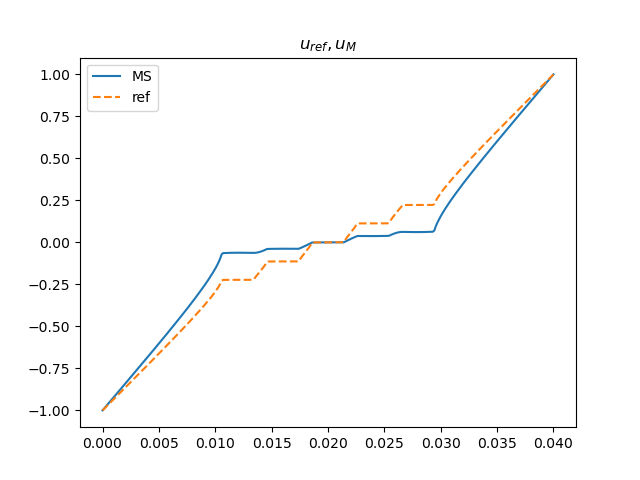

In [56]:

start = -D/2*1.01
end = -D/2*0.9

start = -d/2
end = d/2


plt.figure(2)
start = -D/2
end = D/2

pnt1 = [-d/2*0.99, start, 0] if rotated else [start, -d/2*0.99, 0]
pnt2 = [-d/2*0.99, end, 0] if rotated else [end, -d/2*0.99, 0]


print("sol components", len(sol_comp_MS))
evalOnLine(u_MS , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", clear=True, label="MS", show=False, N=300);
# evalOnLine(sol_comp_MS[0] + sol_comp_MS[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", clear=True, label="MS", show=False, N=300);
# [evalOnLine((sol_comp_MS[i]) , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", clear=False, label="MS_" + cl_gradgradMS.gradsol_pack[i][1].name, show=False, N=1000) for i in range(len(sol_comp_MS))];

# evalOnLine((sol_comp_MS[0]) , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=300);
# evalOnLine((sol_comp_MS[1]) , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=300);
# evalOnLine((sol_comp_MS[2]) , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=300);
evalOnLine(sol_ref , meshRef, pnt1, pnt2, plot=True, ls='--', marker="", show=False, clear=False, label="ref", N = 300, title=r"$u_{ref}, u_{M}$");


plt.legend()
plt.show()

In [18]:
# from ngsolve.webgui import Draw
scene1 = Draw(H_MS[0] ,meshRef, settings={"Objects":{"Wireframe":False}})

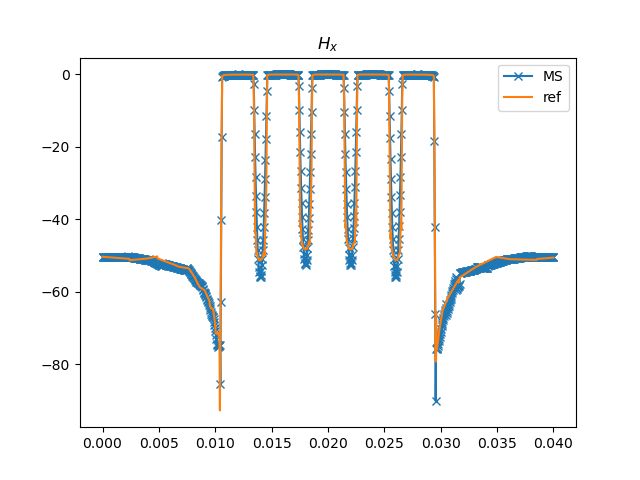

In [19]:
start = -d/2
end = d/2

plt.figure(3)
evalOnLine(H_MS[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-grad(sol_ref)[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_x$");



plt.legend()
plt.show()

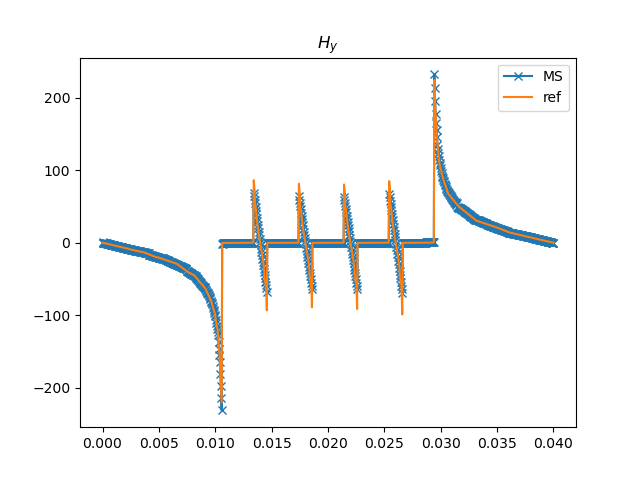

In [20]:
start = -d/2
end = d/2


plt.figure(4)

evalOnLine(H_MS[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
# [evalOnLine((H_comp[i])[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS_" + cl_gradgradMS.gradsol_pack[i][1].name, show=False, N=1000) for i in range(len(H_comp))];

evalOnLine(-grad(sol_ref)[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_y$");
plt.legend()
plt.show()

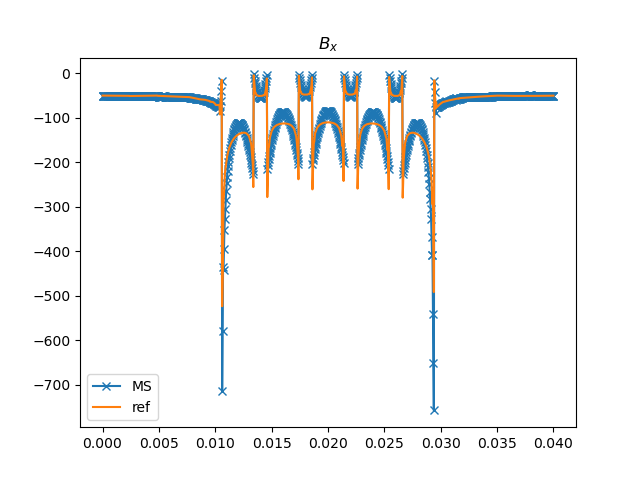

In [21]:
start = -d/2
end = d/2


plt.figure(5)
evalOnLine(lam * H_MS[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
# evalOnLine(lam * (H_comp[0])[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=1000);
evalOnLine(-lam * grad(sol_ref)[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_x$");

plt.legend()
plt.show()

pyLobatto(0)
pydxLobatto(1)
pyLobatto(1)
dxsmoothPhi2
smoothPhi2


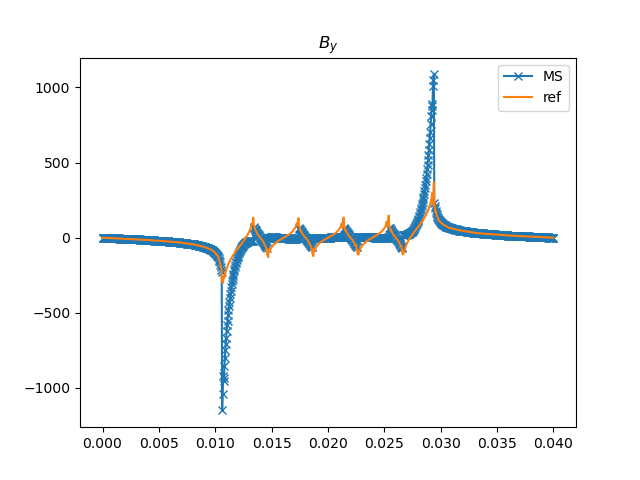

In [22]:
start = -d/2
end = d/2

[print(o[1].name) for o in cl_gradgradMS.gradsol_pack]

plt.figure(6)
evalOnLine(lam * sum(H_comp)[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);

# [evalOnLine(lam * (H_comp[i])[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS_" + cl_gradgradMS.gradsol_pack[i][1].name, show=False, N=1000) for i in range(len(H_comp))];

evalOnLine(-lam * grad(sol_ref)[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_y$");

plt.legend()
plt.show()

In [23]:
print(f"energy:\t{energy_MS}", energy_ref)
Draw(IfPos(y, sol_ref, sum(sol_comp_MS)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})


energy:	0.02357418124678756 0.024428111758319257


In [24]:
Draw(IfPos(y, -grad(sol_ref), H_MS)[1], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=50, min = -50)
Draw(IfPos(y, -grad(sol_ref), H_MS)[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=50, min = -50)

In [25]:
Draw(lam * IfPos(y, -grad(sol_ref), H_MS)[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
Draw(lam * IfPos(y, -grad(sol_ref), H_MS )[1], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
lamMS = IfPos(cl_Phi(0, 0, inIron=False, material="multiscale").phi, lambda1, lambda2)

# Draw(lamMS * IfPos(y, -grad(sol_ref), H_MS)[0], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
# Draw(lamMS * IfPos(y, -grad(sol_ref), H_MS)[1], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -20, max=20)

In [26]:
print("Norm soll diff", Integrate((sum(sol_comp_MS) - sol_ref)* (sum(sol_comp_MS) - sol_ref)/( (sol_ref)**2) , meshRef)*100,  "%")
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, (energy_MS - energy_ref)/energy_ref * 100, "%")



Norm soll diff 33.104351880641694 %
diff energy 0.02357418124678756 0.024428111758319257 -0.0008539305115316982 -3.4956877550753918 %


In [27]:
from ngsolve.webgui import Draw
settings={"Objects":{"Wireframe":False}, "deformation": False}
order = 2

mask = meshRef.MaterialCF({"outer":0}, default=1)
Draw(mask * IfPos(x, cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto).phi.getDiff(), 
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto).dzphi), meshRef, 
                settings = settings)

for order in [0, 1, 2, 3, 4]:
    print(order, Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto).phi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto).phi, meshRef, definedon=meshRef.Materials("insulation|inner")))
    print(order, "_Fe", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto, inAir=False).phi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto, inAir=False).phi, meshRef, definedon=meshRef.Materials("insulation|inner")))
    print(order, "_0", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto, inIron=False).dzphi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto, inIron=False).dzphi, meshRef, definedon=meshRef.Materials("insulation|inner")))
    
    print(order, "dz", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto).dzphi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto).dzphi, meshRef, definedon=meshRef.Materials("insulation|inner")))

    print(order, "dz_Fe", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto, inAir=False).dzphi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto, inAir=False).dzphi, meshRef, definedon=meshRef.Materials("insulation|inner")))
    print(order, "dz_0", Integrate(cl_Phi(order, 0, phiFunction=pyLobatto, dzPhiFunction=pydxLobatto, inIron=False).dzphi- \
                cl_Phi(order, 0, phiFunction=cp.phiFunctions.Lobatto, dzPhiFunction=cp.phiFunctions.dxLobatto, inIron=False).dzphi, meshRef, definedon=meshRef.Materials("insulation|inner")))

    print("=============0")

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. cempy.phiFunctions.Lobatto(xstart: float, d: float, iOrder: int, numSheets: int, ff: float, coordinate: int, inIron: bool = True, inAir: bool = True, inOuter: bool = True, douter: float = nan, fullPhi: bool = False, modelHalfAir: bool = True)

Invoked with: -0.01, 0.004, 2, 5, 0.7, 1; kwargs: inIron=True, inAir=True, inOuter=False, douter=nan, modelHalfAir=False, specialFirstLast=False

In [ ]:
firstRun = False